# Diffusion loss and how it scales

This notebook base heavily on [bending_loss_scale_test](https://github.com/ebrahimebrahim/deep-atlas/blob/main/bending_loss_scale_test.ipynb). 

The motivation of this notebook is to 
1. Generalize the proof of the 1D case given in [bending_loss_scale_test](https://github.com/ebrahimebrahim/deep-atlas/blob/main/bending_loss_scale_test.ipynb) to 3D case (which can be easily extended to n-D cases),
2. Provide a proof of how diffusion loss scales, and
3. Illustrate that the implemented diffusion loss works.

## Analysis of 3D bending energy loss

We define the variables similarly as in [bending_loss_scale_test](https://github.com/ebrahimebrahim/deep-atlas/blob/main/bending_loss_scale_test.ipynb). 
$\def\x{{\mathbf x}}$
$\def\u{{\mathbf u}}$
Let's suppose we have a displacement vector field $\u(\x)$ which represents a deformation.
We consider the 3D case, so $\u(\x))$ and $\x$ are in $\mathbb{R}^3$. Let $$\x = \begin{pmatrix} x \\ y \\ z \end{pmatrix}.$$
We're working with images here, so there's an image domain $D \subseteq \mathbb{R}^3$ which is discretely sampled,
and $\u: D \to \mathbb{R}^3$.

Suppose we want to work with a different image scale, say with $$\lambda = \begin{pmatrix} \lambda_x \\ \lambda_y \\ \lambda_z \end{pmatrix}$$ times as many pixels/voxels along each corresponding axis.
Imagine that images themselves are the "same", and just the resolution is different.

So we rescale the displacement vector field $\u(\x)$ to the new resolution,
obtaining $\hat{\u}: \hat{D} \to \mathbb{R}^3$,
where $\hat{D}$ is the image of $D$ under $$\x \to \lambda \odot \x$$ where $\odot$ is the hadamard product.
We could refer to the function as $\hat{\u}(\hat{\x})$, where 
$$\hat{\x} = \begin{pmatrix} \hat{x} \\ \hat{y} \\ \hat{z} \end{pmatrix} = \begin{pmatrix} \lambda_x x \\ \lambda_y y \\ \lambda_z z \end{pmatrix} = \lambda \odot \x.$$
We denote $$\lambda^{-1} = \begin{pmatrix} \lambda_x^{-1} \\ \lambda_y^{-1} \\ \lambda_z^{-1} \end{pmatrix}.$$
Then we would have $$\hat{\u}(\hat{\x}) = \lambda \odot \u (\x) = \lambda \odot \u (\lambda^{-1} \odot \hat{\x}).\tag{1}$$
This is only approximately true, because $\lambda^{-1}\hat{\x}$ need not be in $D$, which we might imagine to be a discretely sampled rectangle. Let's assume the sampling is fine enough that, or $\lambda$ is chosen such that, this works.

Now recall that the bending energy loss based on $\u$ would be
$$
L(\u) = \frac{1}{|D|}\sum_{\x \in D} \Vert H(\u)(\x) \Vert_F^2
$$
where $H(\u)$ is the Hessian and $\Vert\cdot\Vert_F$ is the frobenius norm.

How does $L(\hat{\u})$ relate to $L(\u)$? One hopes that they'd be roughly equal,
so that bending energy loss is not sensitive to image scale. Let's compute.

Recall that $\hat{x} = \lambda_x x$. Therefore, $$\frac{\partial}{\partial \hat{x}} = \frac{d x}{d \hat{x}}\frac{\partial}{\partial x} = \lambda_x^{-1}\frac{\partial}{\partial x}. \tag{2}$$
So it's easy to derive that
$$
\frac{\partial^2}{\partial \hat{x}^2} \hat{\u}(\hat{\x}) = \lambda_x^{-2} \lambda \odot \frac{\partial^2}{\partial x^2} \u(\lambda^{-1} \odot \hat{\x}). \tag{3}
$$
Similarly, for mixed partials, we have 
$$
\frac{\partial^2}{\partial \hat{x} \partial \hat{y}} \hat{\u}(\hat{\x}) = \lambda_x^{-1} \lambda_y^{-1} \lambda \odot \frac{\partial^2}{\partial x \partial y} \u(\lambda^{-1} \odot \hat{\x}). \tag{4}
$$
Similar equalities hold for other combinations of $x, y, z$. From this point, one could proceed by writing out the terms of the Hessian matrix and substitute the corresponding terms using (3) and (4) while paying attention to the coefficient of each term.

We omit the rest of the proof appeared in [bending_loss_scale_test](https://github.com/ebrahimebrahim/deep-atlas/blob/main/bending_loss_scale_test.ipynb). But readers may feel free to finish the proof.

We now briefly explains how normalization is implemented in [BendingEnergyLoss](https://docs.monai.io/en/stable/losses.html#bendingenergyloss).

Instead of normalizing each second-order partial, the author normalizes every time a partial derivative is taken. Let's look at equation (4), we can further rearrange the terms as following:
$$
\frac{\partial^2}{\partial \hat{x} \partial \hat{y}} \hat{\u}(\hat{\x}) = \lambda_x^{-1} \lambda_y^{-1} \lambda \odot \frac{\partial^2}{\partial x \partial y} \u(\lambda^{-1} \odot \hat{\x}) = \lambda_x^{-1} \frac{\partial}{\partial x}\left( \lambda_y^{-1} \lambda \odot \frac{\partial}{\partial y} \u(\lambda^{-1} \odot \x) \right). 
$$

Therefore, the author decides to $\odot \frac{\lambda_y}{\lambda}$ when taking the partial wrt $y$, and $\odot \lambda_x$ when taking the (second) partial wrt $x$. 

## Analysis of 3D diffusion loss

Using $\u, \hat{\u}, \x, \hat{\x}, D, \hat{D}, \lambda$ as defined above. The diffusion loss is given by 
$$L(\u) = \frac{1}{|D|} \sum_{\x \in D} \Vert \nabla \u \Vert_F^2$$
where $\nabla$ is the spatial gradient.

Using equation (2), we have 
$$\begin{align*}
L(\hat{\u}) 
& = \frac{1}{|\hat{D}|} \sum_{\hat{\x} \in \hat{D}} \Vert \nabla \hat{\u} \Vert_F^2 \\
& = \frac{1}{|\hat{D}|} \sum_{\hat{\x} \in \hat{D}} \left(\frac{\partial \hat{\u}}{\partial \hat{x}}\right)^2 + \left(\frac{\partial \hat{\u}}{\partial \hat{y}}\right)^2 + \left(\frac{\partial \hat{\u}}{\partial \hat{z}}\right)^2 \\
& = \frac{1}{|D|} \sum_{\x \in D} \left( \lambda_x^{-1} \frac{\partial}{\partial x} (\lambda \odot \u(\x)) \right)^2 + \left( \lambda_y^{-1} \frac{\partial}{\partial y} (\lambda \odot \u(\x)) \right)^2 + \left( \lambda_z^{-1} \frac{\partial}{\partial z} (\lambda \odot \u(\x)) \right)^2 \\
& = \frac{1}{|D|} \sum_{\x \in D} \left( \lambda_x^{-1}\lambda \odot  \frac{\partial}{\partial x} (\u(\x)) \right)^2 + \left( \lambda_y^{-1} \lambda \odot \frac{\partial}{\partial y} (\u(\x)) \right)^2 + \left( \lambda_z^{-1} \lambda \odot \frac{\partial}{\partial z} (\u(\x)) \right)^2.
\end{align*}$$

In this case, to normalize the loss, we only need to $\odot \frac{\lambda_x}{\lambda}$ when taking the partial wrt $x$ and similarly for $y, z$.

Observe that when $\lambda_x = \lambda_y = \lambda_z$, diffusion loss is invariant to image resolution (since the the coefficients are 1's).

## Demo

Below we demonstrate the scaling effect in 2D.

In [1]:
from monai import __version__
print(__version__)

1.4.dev2347


In [2]:
from monai.utils import LossReduction
from __future__ import annotations
import torch
from torch.nn.modules.loss import _Loss
from utils import plot_2D_vector_field, jacobian_determinant
import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def spatial_gradient(x: torch.Tensor, dim: int) -> torch.Tensor:
    """
    Calculate gradients on single dimension of a tensor using central finite difference.
    It moves the tensor along the dimension to calculate the approximate gradient
    dx[i] = (x[i+1] - x[i-1]) / 2.
    Adapted from:
        DeepReg (https://github.com/DeepRegNet/DeepReg)

    Args:
        x: the shape should be BCH(WD).
        dim: dimension to calculate gradient along.
    Returns:
        gradient_dx: the shape should be BCH(WD)
    """
    slice_1 = slice(1, -1)
    slice_2_s = slice(2, None)
    slice_2_e = slice(None, -2)
    slice_all = slice(None)
    slicing_s, slicing_e = [slice_all, slice_all], [slice_all, slice_all]
    while len(slicing_s) < x.ndim:
        slicing_s = slicing_s + [slice_1]
        slicing_e = slicing_e + [slice_1]
    slicing_s[dim] = slice_2_s
    slicing_e[dim] = slice_2_e
    return (x[slicing_s] - x[slicing_e]) / 2.0
    
class DiffusionLoss(_Loss):
    """
    Calculate the diffusion based on first-order differentiation of pred using central finite difference.
    For the original paper, please refer to
    VoxelMorph: A Learning Framework for Deformable Medical Image Registration,
    Guha Balakrishnan, Amy Zhao, Mert R. Sabuncu, John Guttag, Adrian V. Dalca
    IEEE TMI: Transactions on Medical Imaging. 2019. eprint arXiv:1809.05231.

    Adapted from:
        VoxelMorph (https://github.com/voxelmorph/voxelmorph)
    """

    def __init__(self, normalize: bool = False, reduction: LossReduction | str = LossReduction.MEAN) -> None:
        """
        Args:
            normalize:
                Whether to divide out spatial sizes in order to make the computation roughly
                invariant to image scale (i.e. vector field sampling resolution). Defaults to False.
            reduction: {``"none"``, ``"mean"``, ``"sum"``}
                Specifies the reduction to apply to the output. Defaults to ``"mean"``.

                - ``"none"``: no reduction will be applied.
                - ``"mean"``: the sum of the output will be divided by the number of elements in the output.
                - ``"sum"``: the output will be summed.
        """
        super().__init__(reduction=LossReduction(reduction).value)
        self.normalize = normalize

    def forward(self, pred: torch.Tensor) -> torch.Tensor:
        """
                Args:
                    pred: the shape should be BCH(WD)

                Raises:
                    ValueError: When ``self.reduction`` is not one of ["mean", "sum", "none"].

                """
        if pred.ndim not in [3, 4, 5]:
            raise ValueError(f"Expecting 3-d, 4-d or 5-d pred, instead got pred of shape {pred.shape}")
        for i in range(pred.ndim - 2):
            if pred.shape[-i - 1] <= 4:
                raise ValueError(f"All spatial dimensions must be > 4, got spatial dimensions {pred.shape[2:]}")
        if pred.shape[1] != pred.ndim - 2:
            raise ValueError(
                f"Number of vector components, {pred.shape[1]}, does not match number of spatial dimensions, {pred.ndim - 2}"
            )

        # first order gradient
        first_order_gradient = [spatial_gradient(pred, dim) for dim in range(2, pred.ndim)]

        # spatial dimensions in a shape suited for broadcasting below
        if self.normalize:
            spatial_dims = torch.tensor(pred.shape, device=pred.device)[2:].reshape((1, -1) + (pred.ndim - 2) * (1,))

        diffusion = torch.tensor(0)
        for dim_1, g in enumerate(first_order_gradient):
            dim_1 += 2
            if self.normalize:
                g *= pred.shape[dim_1] / spatial_dims
            diffusion = diffusion + g ** 2

        if self.reduction == LossReduction.MEAN.value:
            diffusion = torch.mean(diffusion)  # the batch and channel average
        elif self.reduction == LossReduction.SUM.value:
            diffusion = torch.sum(diffusion)  # sum over the batch and channel dims
        elif self.reduction != LossReduction.NONE.value:
            raise ValueError(f'Unsupported reduction: {self.reduction}, available options are ["mean", "sum", "none"].')

        return diffusion

In [4]:
diffusion_loss = DiffusionLoss(normalize=False)
diffusion_loss_normed = DiffusionLoss(normalize=True)

Recall earlier we discussed how normalization does *not* matter when the sptial resolutions on all axes are the same. Therefore, to illustrate the effect of normalization, we consider the case where $y$-axis is twice the scale as $x$-axis.

In [5]:
def get_example_loss_at_scale(s):
    ddf = torch.tensor(
        [[
            [(s/32)*2*math.cos(2*math.pi* (x/s) * 3),(s/32)*math.sin(2*math.pi*(y/s) * 5)]
            for x in range(s)]
            for y in range(2*s)
        ]
    ).permute((2,0,1))
    L = diffusion_loss(ddf.unsqueeze(0))
    if (s<80):
        plot_2D_vector_field(ddf, 1)
        plt.show()
        print(f"Diffusion loss at scale {s}: {L}")
    return L.item()

def get_example_loss_at_scale_normed(s):
    ddf = torch.tensor(
        [[
            [(s/32)*2*math.cos(2*math.pi* (x/s) * 3),(s/32)*math.sin(2*math.pi*(y/s) * 5)]
            for x in range(s)]
            for y in range(2*s)
        ]
    ).permute((2,0,1))
    L = diffusion_loss_normed(ddf.unsqueeze(0))
    if (s<80):
        plot_2D_vector_field(ddf, 1)
        plt.show()
        print(f"Diffusion loss at scale {s}: {L}")
    return L.item()

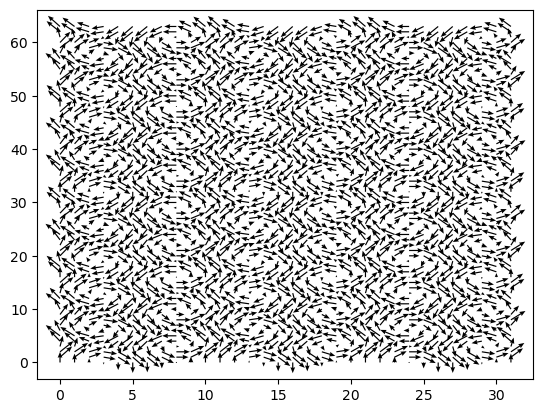

Diffusion loss at scale 32: 0.49399876594543457


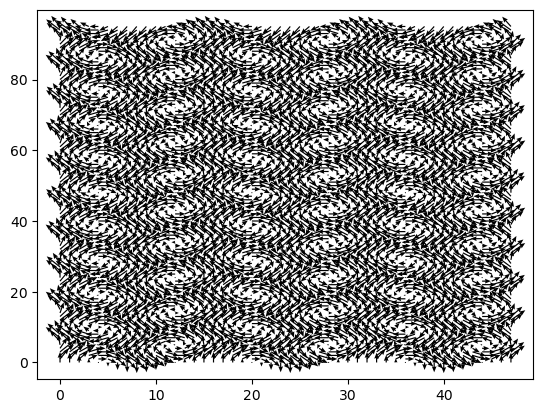

Diffusion loss at scale 48: 0.5473987460136414


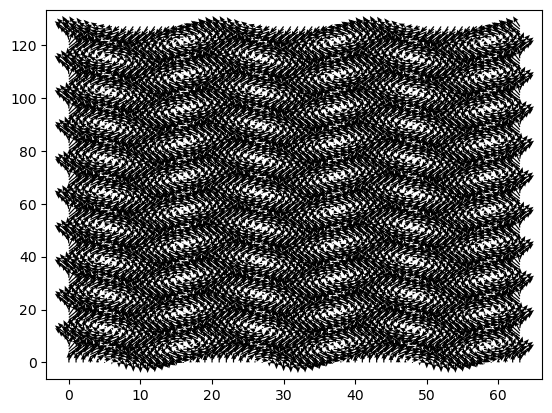

Diffusion loss at scale 64: 0.5664889812469482


In [6]:
loss_by_scale = [(s,get_example_loss_at_scale(s)) for s in range(32, 512,16)]

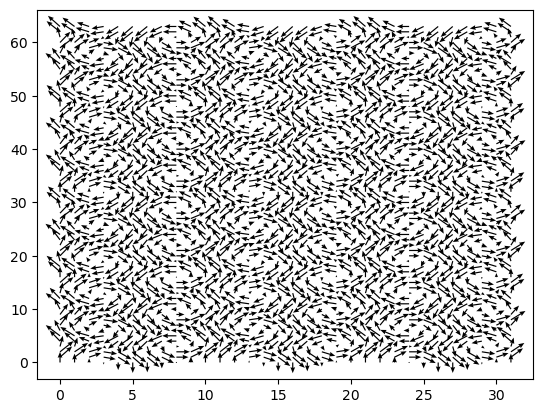

Diffusion loss at scale 32: 0.7651793360710144


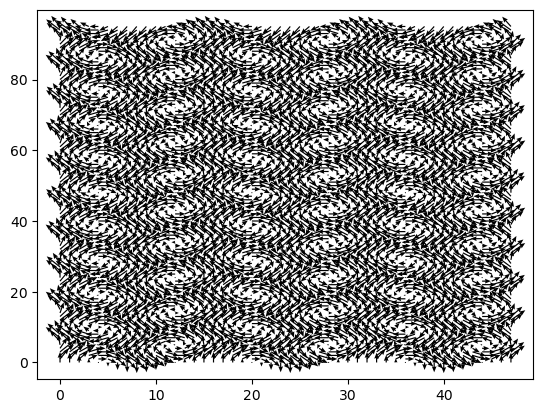

Diffusion loss at scale 48: 0.9080954790115356


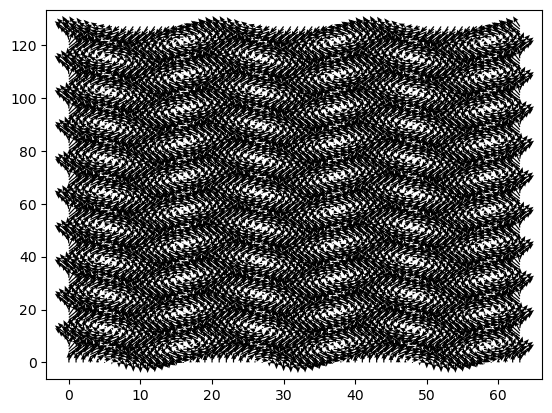

Diffusion loss at scale 64: 0.964640200138092


In [7]:
loss_by_scale_normed = [(s,get_example_loss_at_scale_normed(s)) for s in range(32, 512,16)]

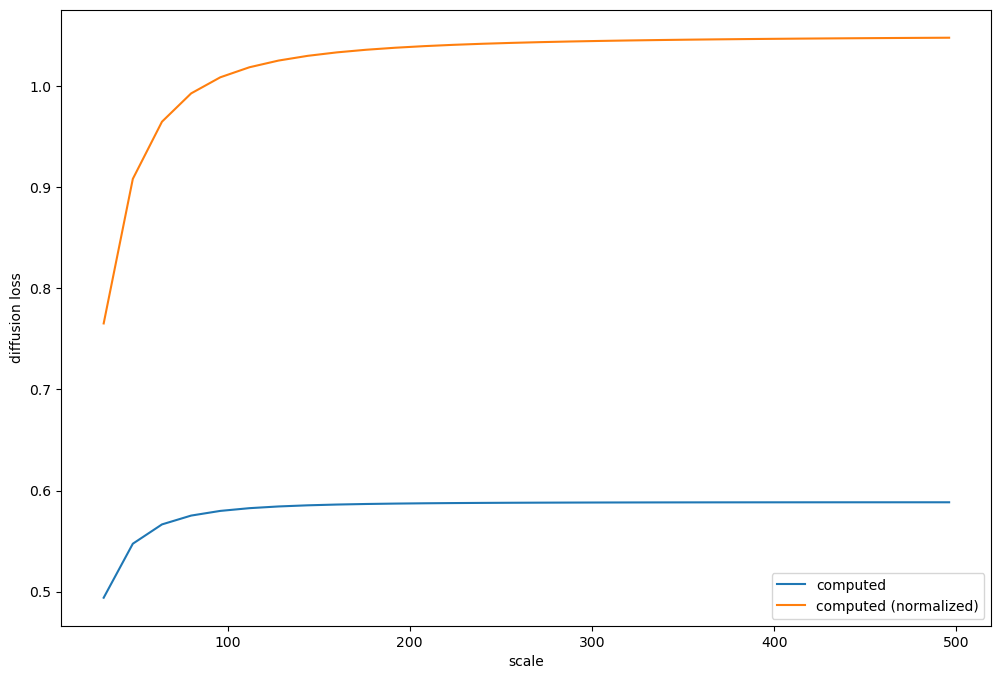

In [8]:
%matplotlib inline
loss_by_scale = np.array(loss_by_scale)
loss_by_scale_normed = np.array(loss_by_scale_normed)
scales = loss_by_scale[:,0]
_,l0 = loss_by_scale[-1]
plt.figure(figsize=(12,8))
plt.plot(scales,loss_by_scale[:,1], label='computed')
plt.plot(scales,loss_by_scale_normed[:,1], label='computed (normalized)')
# plt.plot(scales, [l0 for s in scales], label='estimated from analysis')
plt.xlabel('scale')
plt.ylabel('diffusion loss')
# plt.yscale('log')
plt.legend()
plt.show()

There is not an straight forward way to calculate the estimated diffusion loss from analysis when axes have different resolutions. We include the case where axes are of equal resolutions to illustrate how approximations lead to deviation from analysis at lower resolutions.

In [9]:
def get_example_loss_at_scale(s):
    ddf = torch.tensor(
        [[
            [(s/32)*2*math.cos(2*math.pi* (x/s) * 3),(s/32)*math.sin(2*math.pi*(y/s) * 5)]
            for x in range(s)]
            for y in range(s)
        ]
    ).permute((2,0,1))
    L = diffusion_loss(ddf.unsqueeze(0))
    if (s<80):
        plot_2D_vector_field(ddf, 1)
        plt.show()
        print(f"Diffusion loss at scale {s}: {L}")
    return L.item()

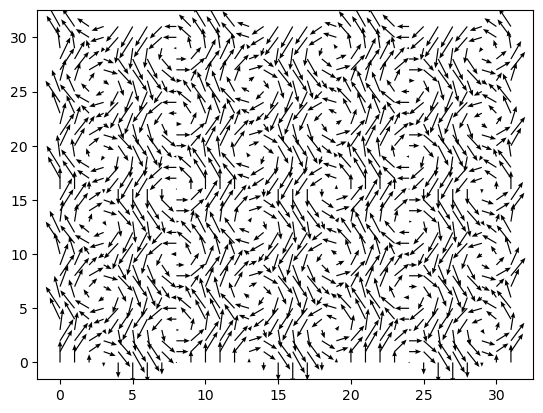

Diffusion loss at scale 32: 0.4921630918979645


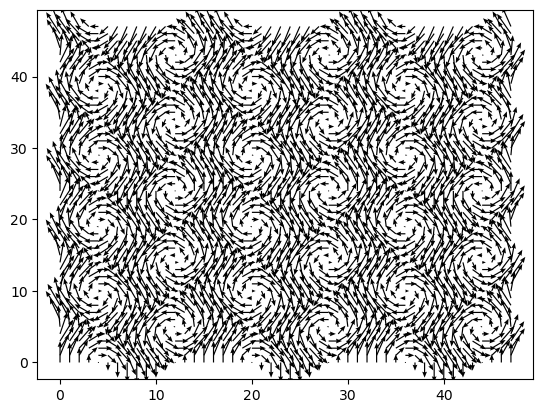

Diffusion loss at scale 48: 0.5444856882095337


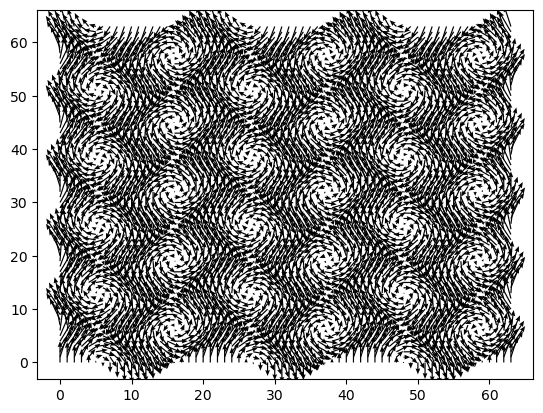

Diffusion loss at scale 64: 0.5636570453643799


In [10]:
loss_by_scale = [(s,get_example_loss_at_scale(s)) for s in range(32, 512,16)]

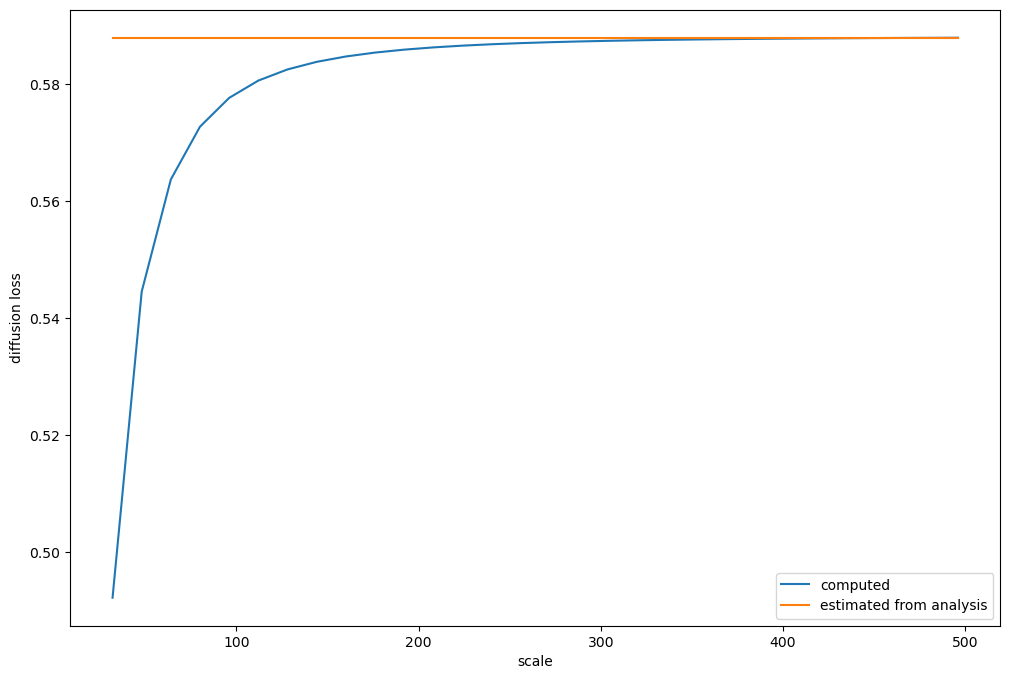

In [11]:
%matplotlib inline
loss_by_scale = np.array(loss_by_scale)
loss_by_scale_normed = np.array(loss_by_scale_normed)
scales = loss_by_scale[:,0]
_,l0 = loss_by_scale[-1]
plt.figure(figsize=(12,8))
plt.plot(scales,loss_by_scale[:,1], label='computed')
# plt.plot(scales,loss_by_scale_normed[:,1], label='computed (normalized)')
plt.plot(scales, [l0 for s in scales], label='estimated from analysis')
plt.xlabel('scale')
plt.ylabel('diffusion loss')
# plt.yscale('log')
plt.legend()
plt.show()

Note that at lower resolutions the computed result disagrees a little with the analysis-- this is because the analysis makes the assumption (1) above, which fails at low resolutions. Also there's the "$\approx$" step in the calculation, which is less true at low resolutions for fixed smooth vector fields.

Play with `s_x` and `s_y` in a couple of examples below and observe that this results in a scale invariant version of bending loss.

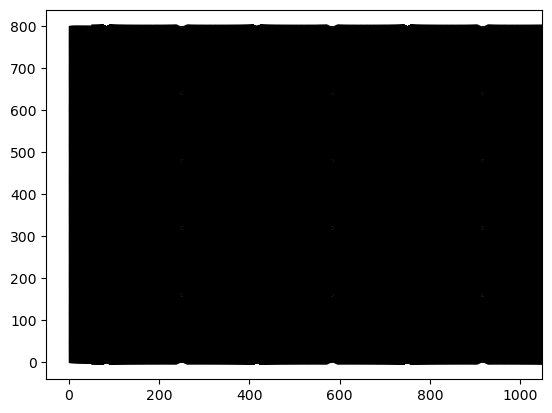

tensor(0.5879)


In [12]:
s_x=1000
s_y=800
ddf = torch.tensor(
    [[
        [(s_y/32)*math.sin(2*math.pi*(y/s_y) * 5),(s_x/32)*2*math.cos(2*math.pi* (x/s_x) * 3)]
        for x in range(s_x)]
        for y in range(s_y)
    ]
).permute((2,0,1))
plot_2D_vector_field(ddf, 1)
plt.show()
L = DiffusionLoss(normalize=True)(ddf.unsqueeze(0))
print(L)

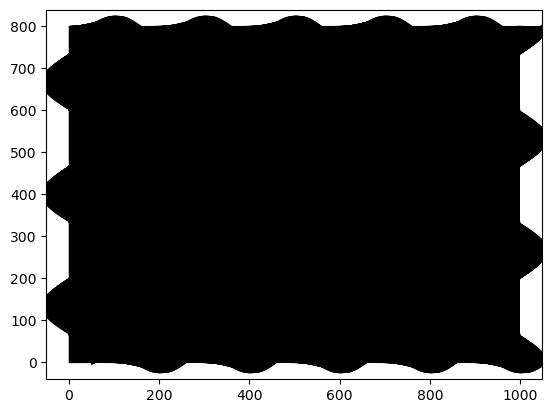

tensor(0.6973)


In [13]:
s_x=1000
s_y=800
ddf = torch.tensor(
    [[
        [(s_y/32)*math.sin(2*math.pi*(x/s_x) * 5),(s_x/32)*2*math.cos(2*math.pi* (y/s_y) * 3)]
        for x in range(s_x)]
        for y in range(s_y)
    ]
).permute((2,0,1))
plot_2D_vector_field(ddf, 1)
plt.show()
L = DiffusionLoss(normalize=False)(ddf.unsqueeze(0))
print(L)